# Backpropagation in Multilayer Neural Networks

### Goals:
- Diving deep: implement a real gradient descent in `Numpy`

### Dataset:
- Similar as first Lab - Digits: 10 class handwritten digits
- [sklearn.datasets.load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits)

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

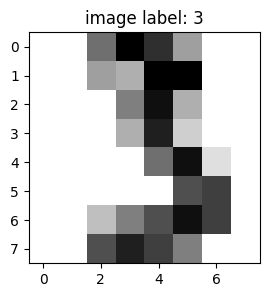

In [5]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[0.00000000e+00 2.98624754e-01 5.19253438e+00 1.18428291e+01
 1.18565815e+01 5.81008513e+00 1.34774067e+00 1.19187950e-01
 6.54878847e-03 1.99345121e+00 1.03464309e+01 1.19305828e+01
 1.02626064e+01 8.20497708e+00 1.84348396e+00 9.88867060e-02
 3.27439424e-03 2.61624100e+00 9.83497053e+00 6.87098887e+00
 7.11263916e+00 7.83759005e+00 1.75376555e+00 4.45317616e-02
 1.30975769e-03 2.48788474e+00 9.04453176e+00 8.73280943e+00
 9.98231827e+00 7.57105435e+00 2.26850033e+00 2.61951539e-03
 0.00000000e+00 2.36149312e+00 7.68369352e+00 9.07924034e+00
 1.03713163e+01 8.79240341e+00 2.89980354e+00 0.00000000e+00
 8.51342502e-03 1.57039948e+00 6.84937787e+00 7.22855272e+00
 7.65029470e+00 8.26522593e+00 3.48592010e+00 2.61951539e-02
 8.51342502e-03 6.83693517e-01 7.49312377e+00 9.56516045e+00
 9.36869679e+00 8.77668631e+00 3.76686313e+00 2.08906352e-01
 6.54878847e-04 2.78978389e-01 5.53700065e+00 1.20595940e+01
 1.17832351e+01 6.81990832e+00 2.07465619e+00 3.42501637e-01]
[1.         0.91047427 

In [7]:
X_train.shape

(1527, 64)

In [8]:
X_train.dtype

dtype('float32')

In [9]:
X_test.shape

(270, 64)

In [10]:
y_train.shape

(1527,)

In [11]:
y_train.dtype

dtype('int32')

# Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

- Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

- Build a predict function which returns the most probable class given an input $x$

- Build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

- Build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

- Build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [12]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [13]:
one_hot(n_classes=10, y=3)

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [14]:
one_hot(n_classes=10, y=[0, 4, 9, 1])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [15]:
def softmax(X):
    # TODO:
    e_x = np.exp(X-np.max(X))
    return e_x/sum(e_x)

Make sure that this works one vector at a time (and check that the components sum to one):

In [16]:
print(softmax([10, 100, 5, 4, 2, -3]))

print(sum(softmax([10, 2, -3])))


[8.19401262e-40 1.00000000e+00 5.52108228e-42 2.03109266e-42
 2.74878501e-43 1.85211677e-45]
1.0


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [17]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

[[9.99983299e-01 4.74258732e-02 9.99999959e-01]
 [1.67014218e-05 9.52574127e-01 4.13993755e-08]]


Here is a way to implement softmax that works both for an individual vector of activations and for a batch of activation vectors at once:

In [18]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))

softmax of a single vector:
[9.99662391e-01 3.35349373e-04 2.25956630e-06]


Probabilities should sum to 1:

In [19]:
print(np.sum(softmax([10, 2, -3])))

1.0


In [20]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

sotfmax of 2 vectors:
[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]


The sum of probabilities for each input vector of logits should some to 1:

In [21]:
print(np.sum(softmax(X), axis=1))

[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [22]:
def nll(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)


    epsilon = 1e-15

    #Take one hot encoding vector
    #Multiply witha all Y_pred
    #Sum them, make negative
    prob = -np.sum(Y_true * np.log(Y_pred+epsilon))
    return prob


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

0.010050335853500441


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [23]:
print(nll([0, 0, 1], [0.01, 0.01, .98]))

0.020202707317518446


Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [24]:
def nll(Y_true, Y_pred):
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)

    epsilon = 1e-15
    prob = np.sum(-np.sum(Y_true * np.log(Y_pred + epsilon), axis=0, keepdims=True))

    return prob


In [25]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

0.01005033585349822


Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [26]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size

    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]

    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [27]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 3716.4279, train acc: 0.094, test acc: 0.111


Evaluate the randomly initialized model on the first example:

/tmp/ipython-input-1375347835.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)'


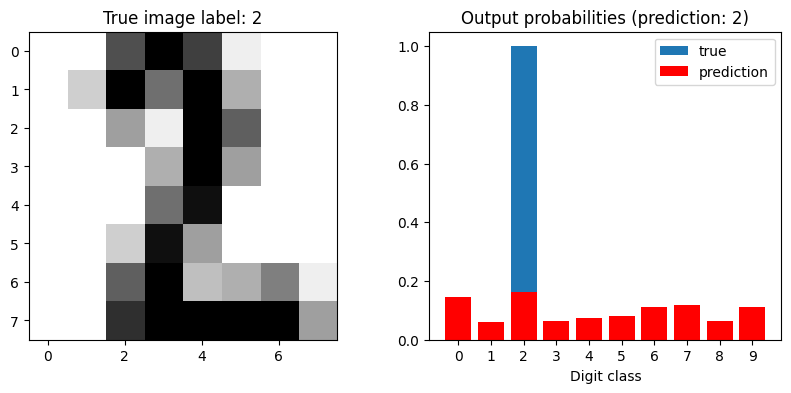

In [28]:
def plot_prediction(model, sample_idx=0, classes=range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

    # FIX 1: Reshape for the scaler
    # We select the sample and immediately reshape it to (1, 64)
    sample_data = X_test[sample_idx].reshape(1, -1)

    # Now scaler works because it receives a 2D array
    # We select [0] at the end to turn it back into a simple image for plotting
    ax0.imshow(scaler.inverse_transform(sample_data).reshape(8, 8), cmap=plt.cm.gray_r,
               interpolation='nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx])

    ax1.bar(classes, one_hot(len(classes), y_test[sample_idx]), label='true')

    # FIX 2: Reshape for the model forward pass
    # Depending on your implementation, forward() likely returns a shape (1, 10)
    # We use .flatten() or [0] to get a clean 1D list for the bar chart
    pred_probs = model.forward(sample_data)
    ax1.bar(classes, pred_probs.flatten(), label='prediction', color="red")

    ax1.set_xticks(classes)

    # FIX 3: Reshape for the prediction
    prediction = model.predict(sample_data)

    # Note: If predict returns an array like [7], we might need prediction[0] or item()
    # to print it cleanly in the title, but usually %d handles single-item arrays okay.
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(lr, sample_idx=0)

In [29]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

Update #0, train loss: 3691.7278, train acc: 0.102, test acc: 0.104
Update #100, train loss: 2042.2521, train acc: 0.735, test acc: 0.748
Update #200, train loss: 1308.3826, train acc: 0.875, test acc: 0.896
Update #300, train loss: 966.2123, train acc: 0.912, test acc: 0.919
Update #400, train loss: 806.9460, train acc: 0.910, test acc: 0.922
Update #500, train loss: 700.8941, train acc: 0.919, test acc: 0.930
Update #600, train loss: 611.8195, train acc: 0.929, test acc: 0.930
Update #700, train loss: 556.3263, train acc: 0.934, test acc: 0.944
Update #800, train loss: 525.8254, train acc: 0.942, test acc: 0.952
Update #900, train loss: 488.7660, train acc: 0.942, test acc: 0.944
Update #1000, train loss: 451.3222, train acc: 0.949, test acc: 0.952
Update #1100, train loss: 425.1465, train acc: 0.947, test acc: 0.952
Update #1200, train loss: 408.6970, train acc: 0.948, test acc: 0.970
Update #1300, train loss: 391.8251, train acc: 0.950, test acc: 0.944
Update #1400, train loss: 370

Evaluate the trained model on the first example:

/tmp/ipython-input-1375347835.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)'


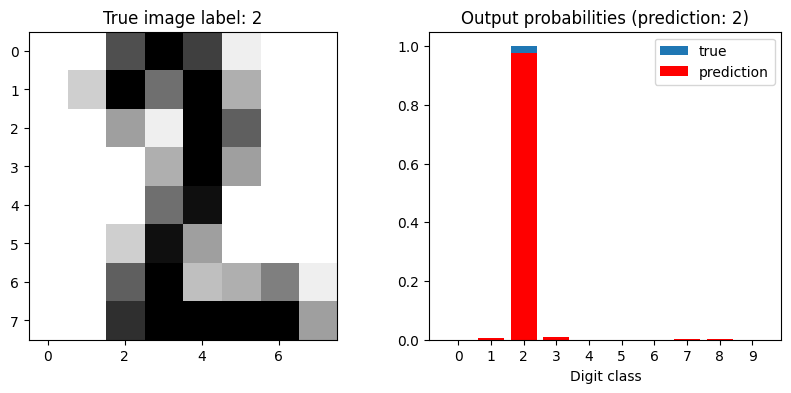

In [30]:
plot_prediction(lr, sample_idx=0)

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

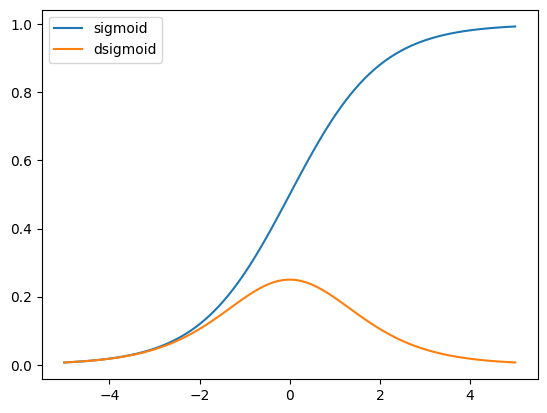

In [31]:
def sigmoid(X):
    return 1/(1+np.exp(-X))


def dsigmoid(X):
    return sigmoid(X)*(1-sigmoid(X))


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid(\mathbf{W}^h \mathbf{x} + \mathbf{b^h})$
  - $\mathbf{y} = softmax(\mathbf{W}^o \mathbf{h} + \mathbf{b^o})$

- Notes:
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- Update the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

**Bonus**: reimplementing all from scratch only using the lecture slides but without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [32]:
class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(
            size=(input_size, hidden_size), high=0.01, low=-0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(
            size=(hidden_size, output_size), high=0.01, low=-0.01)
        self.b_o =np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X):
        h = sigmoid(np.dot(X, self.W_h) + self.b_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y

    def forward_keep_activations(self, X):
        z_h = np.dot(X, self.W_h) + self.b_h
        h = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y = softmax(z_o)
        return y, h, z_h

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, X, y_true):
        y, h, z_h = self.forward_keep_activations(X)
        grad_z_o = y - one_hot(self.output_size, y_true)

        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        grads = {"W_h": grad_W_h, "b_h": grad_b_h,
                 "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        # Traditional SGD update on one sample at a time
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [33]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [34]:
model.loss(X_train, y_train)

np.float64(3516.2354064831916)

In [35]:
model.accuracy(X_train, y_train)

np.float64(0.10150622134905042)

/tmp/ipython-input-1375347835.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)'


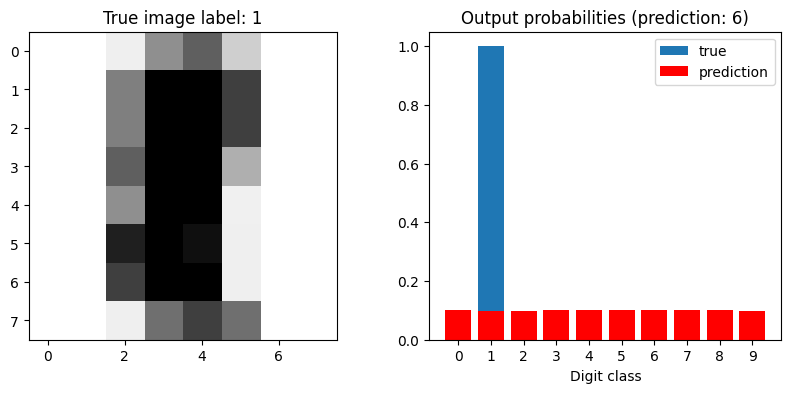

In [36]:
plot_prediction(model, sample_idx=5)

In [37]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 3516.23541, train acc: 0.102, test acc: 0.096
Epoch #1, train loss: 671.10574, train acc: 0.862, test acc: 0.826
Epoch #2, train loss: 287.06822, train acc: 0.957, test acc: 0.926
Epoch #3, train loss: 196.50626, train acc: 0.972, test acc: 0.933
Epoch #4, train loss: 146.51688, train acc: 0.980, test acc: 0.941
Epoch #5, train loss: 110.58582, train acc: 0.986, test acc: 0.952
Epoch #6, train loss: 88.74589, train acc: 0.991, test acc: 0.952
Epoch #7, train loss: 73.84396, train acc: 0.993, test acc: 0.952
Epoch #8, train loss: 63.26235, train acc: 0.995, test acc: 0.959
Epoch #9, train loss: 55.14832, train acc: 0.995, test acc: 0.956
Epoch #10, train loss: 49.03768, train acc: 0.996, test acc: 0.959
Epoch #11, train loss: 43.70970, train acc: 0.997, test acc: 0.959
Epoch #12, train loss: 39.30262, train acc: 0.997, test acc: 0.959
Epoch #13, train loss: 35.74743, train acc: 0.997, test acc: 0.959
Epoch #14, train loss: 32.21056, train acc: 0.998, test acc: 0

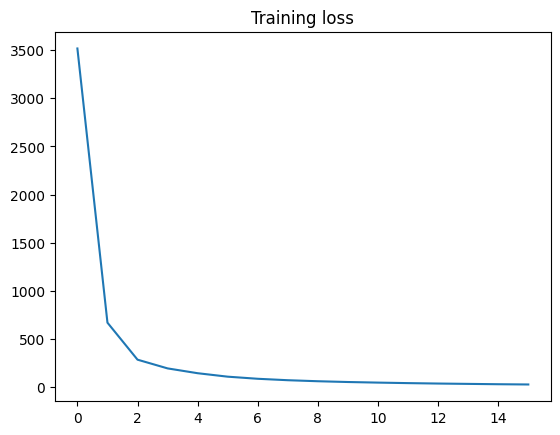

In [38]:
plt.plot(losses)
plt.title("Training loss");

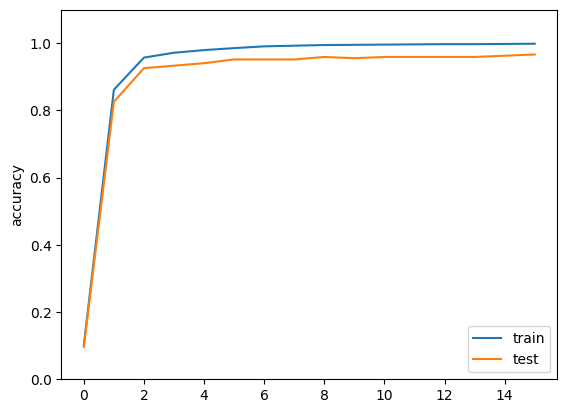

In [39]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

/tmp/ipython-input-1375347835.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_title('Output probabilities (prediction: %d)'


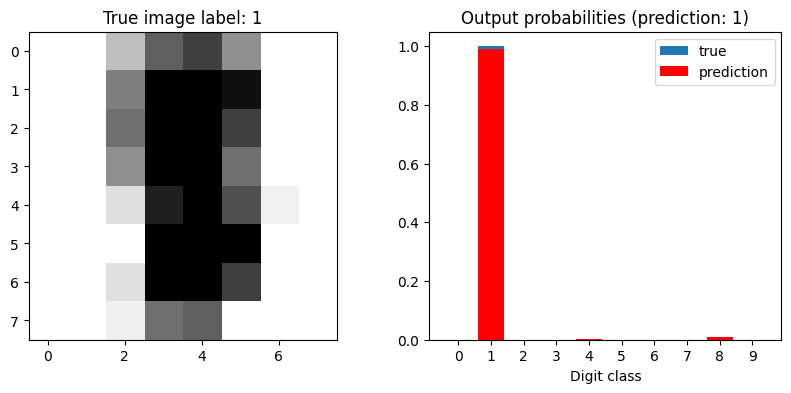

In [40]:
plot_prediction(model, sample_idx=4)

## c) Exercises

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum



## Homework assignments

- Watch the following video on [how to code a minimal deep learning framework](https://www.youtube.com/watch?v=o64FV-ez6Gw)

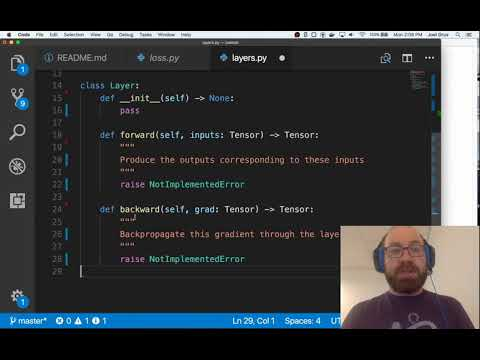

In [41]:
from IPython.display import YouTubeVideo
YouTubeVideo("o64FV-ez6Gw")

- **Optional**: read the following blog post on Reverse-Mode Automatic Differentiation from start to section "A simple implementation in Python" included:

  https://rufflewind.com/2016-12-30/reverse-mode-automatic-differentiation